In [31]:
import folium
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt
import matplotlib.pyplot as plt
data = pd.read_csv('GPS_data_projekti.csv')
df = pd.read_csv('Acceleration_data_projekti.csv')

In [14]:
#Karttakuva liikkumisesta
location_frame = data[['latitude','longitude']] #Luodaan Pandas data frame, jossa sarakkeina latitudi ja longitudi
location_list = location_frame.values.tolist() #Luodaan framesta lista
ave_lat = np.mean(location_list,axis = 0)[0]
ave_lon = np.mean(location_list,axis = 0)[1]

my_map = folium.Map(location=[ave_lat, ave_lon], zoom_start=14)
folium.PolyLine(location_list, color="red", weight=2.5, opacity=1).add_to(my_map)
my_map.save("projekti_map.html")

In [13]:
def haversine(lon1, lat1, lon2, lat2):
    """ 
    Calculate the great circle distance in kilometers between two points on the earth (specified in decimal degrees)
    """ 
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of earth in kilometers.
    return c * r

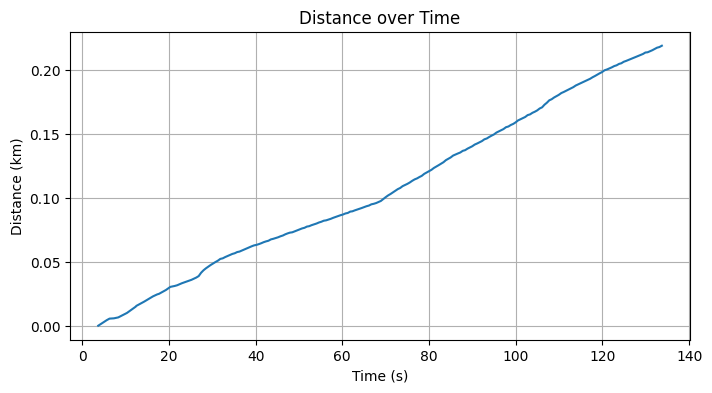

Ensimmäisen ja viimeisen pisteen karkea etäisyys on 210m, aikaa kuluisi kävellen 3min Google Maps mukaan


In [21]:
#Etäisyyden kuvaaja
def calculate_distance(row):
    if row.name == 0:
        return 0
    else:
        previous_row = data.iloc[row.name - 1]
        return haversine(previous_row['longitude'], previous_row['latitude'], row['longitude'], row['latitude'])

data['distance_from_previous'] = data.apply(calculate_distance, axis=1)

# Laske kumulatiivinen summa
cumulative_distance = data['distance_from_previous'].cumsum()

plt.figure(figsize=(8, 4))
plt.plot(data['seconds_elapsed'], cumulative_distance)
plt.xlabel('Time (s)')
plt.ylabel('Distance (km)')
plt.title('Distance over Time')
plt.grid(True)
plt.show()

print("Ensimmäisen ja viimeisen pisteen karkea etäisyys on 210m, aikaa kuluisi kävellen 3min Google Maps mukaan")

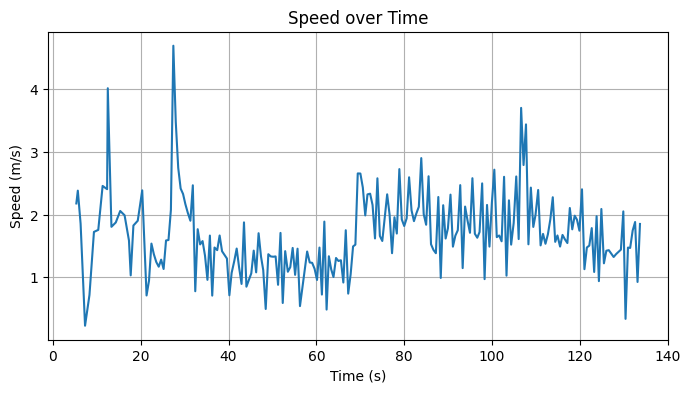

In [29]:
#Nopeuden kuvaaja
data['time_difference'] = data['seconds_elapsed'].diff().fillna(0)
data['speed'] = (data['distance_from_previous'] / data['time_difference']) * 1000

plt.figure(figsize=(8, 4))
plt.plot(data['seconds_elapsed'], data['speed'])
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.title('Speed over Time')
plt.grid(True)
plt.show()

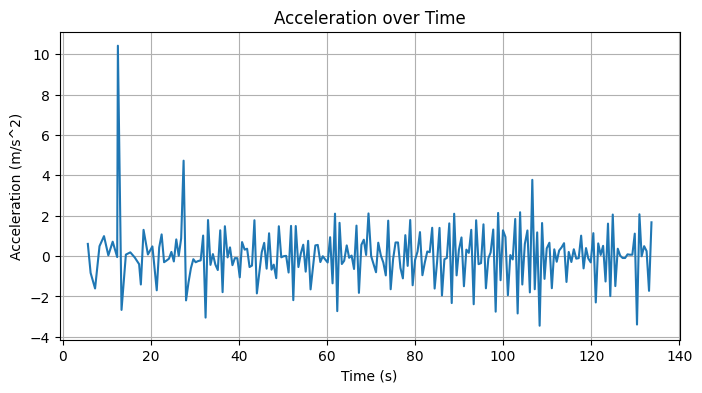

In [30]:
#Kiihtyvyyden kuvaaja, nopeudesta laskettu
data['acceleration'] = data['speed'].diff() / data['time_difference']

plt.figure(figsize=(8, 4))
plt.plot(data['seconds_elapsed'], data['acceleration'])
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.title('Acceleration over Time')
plt.grid(True)
plt.show()

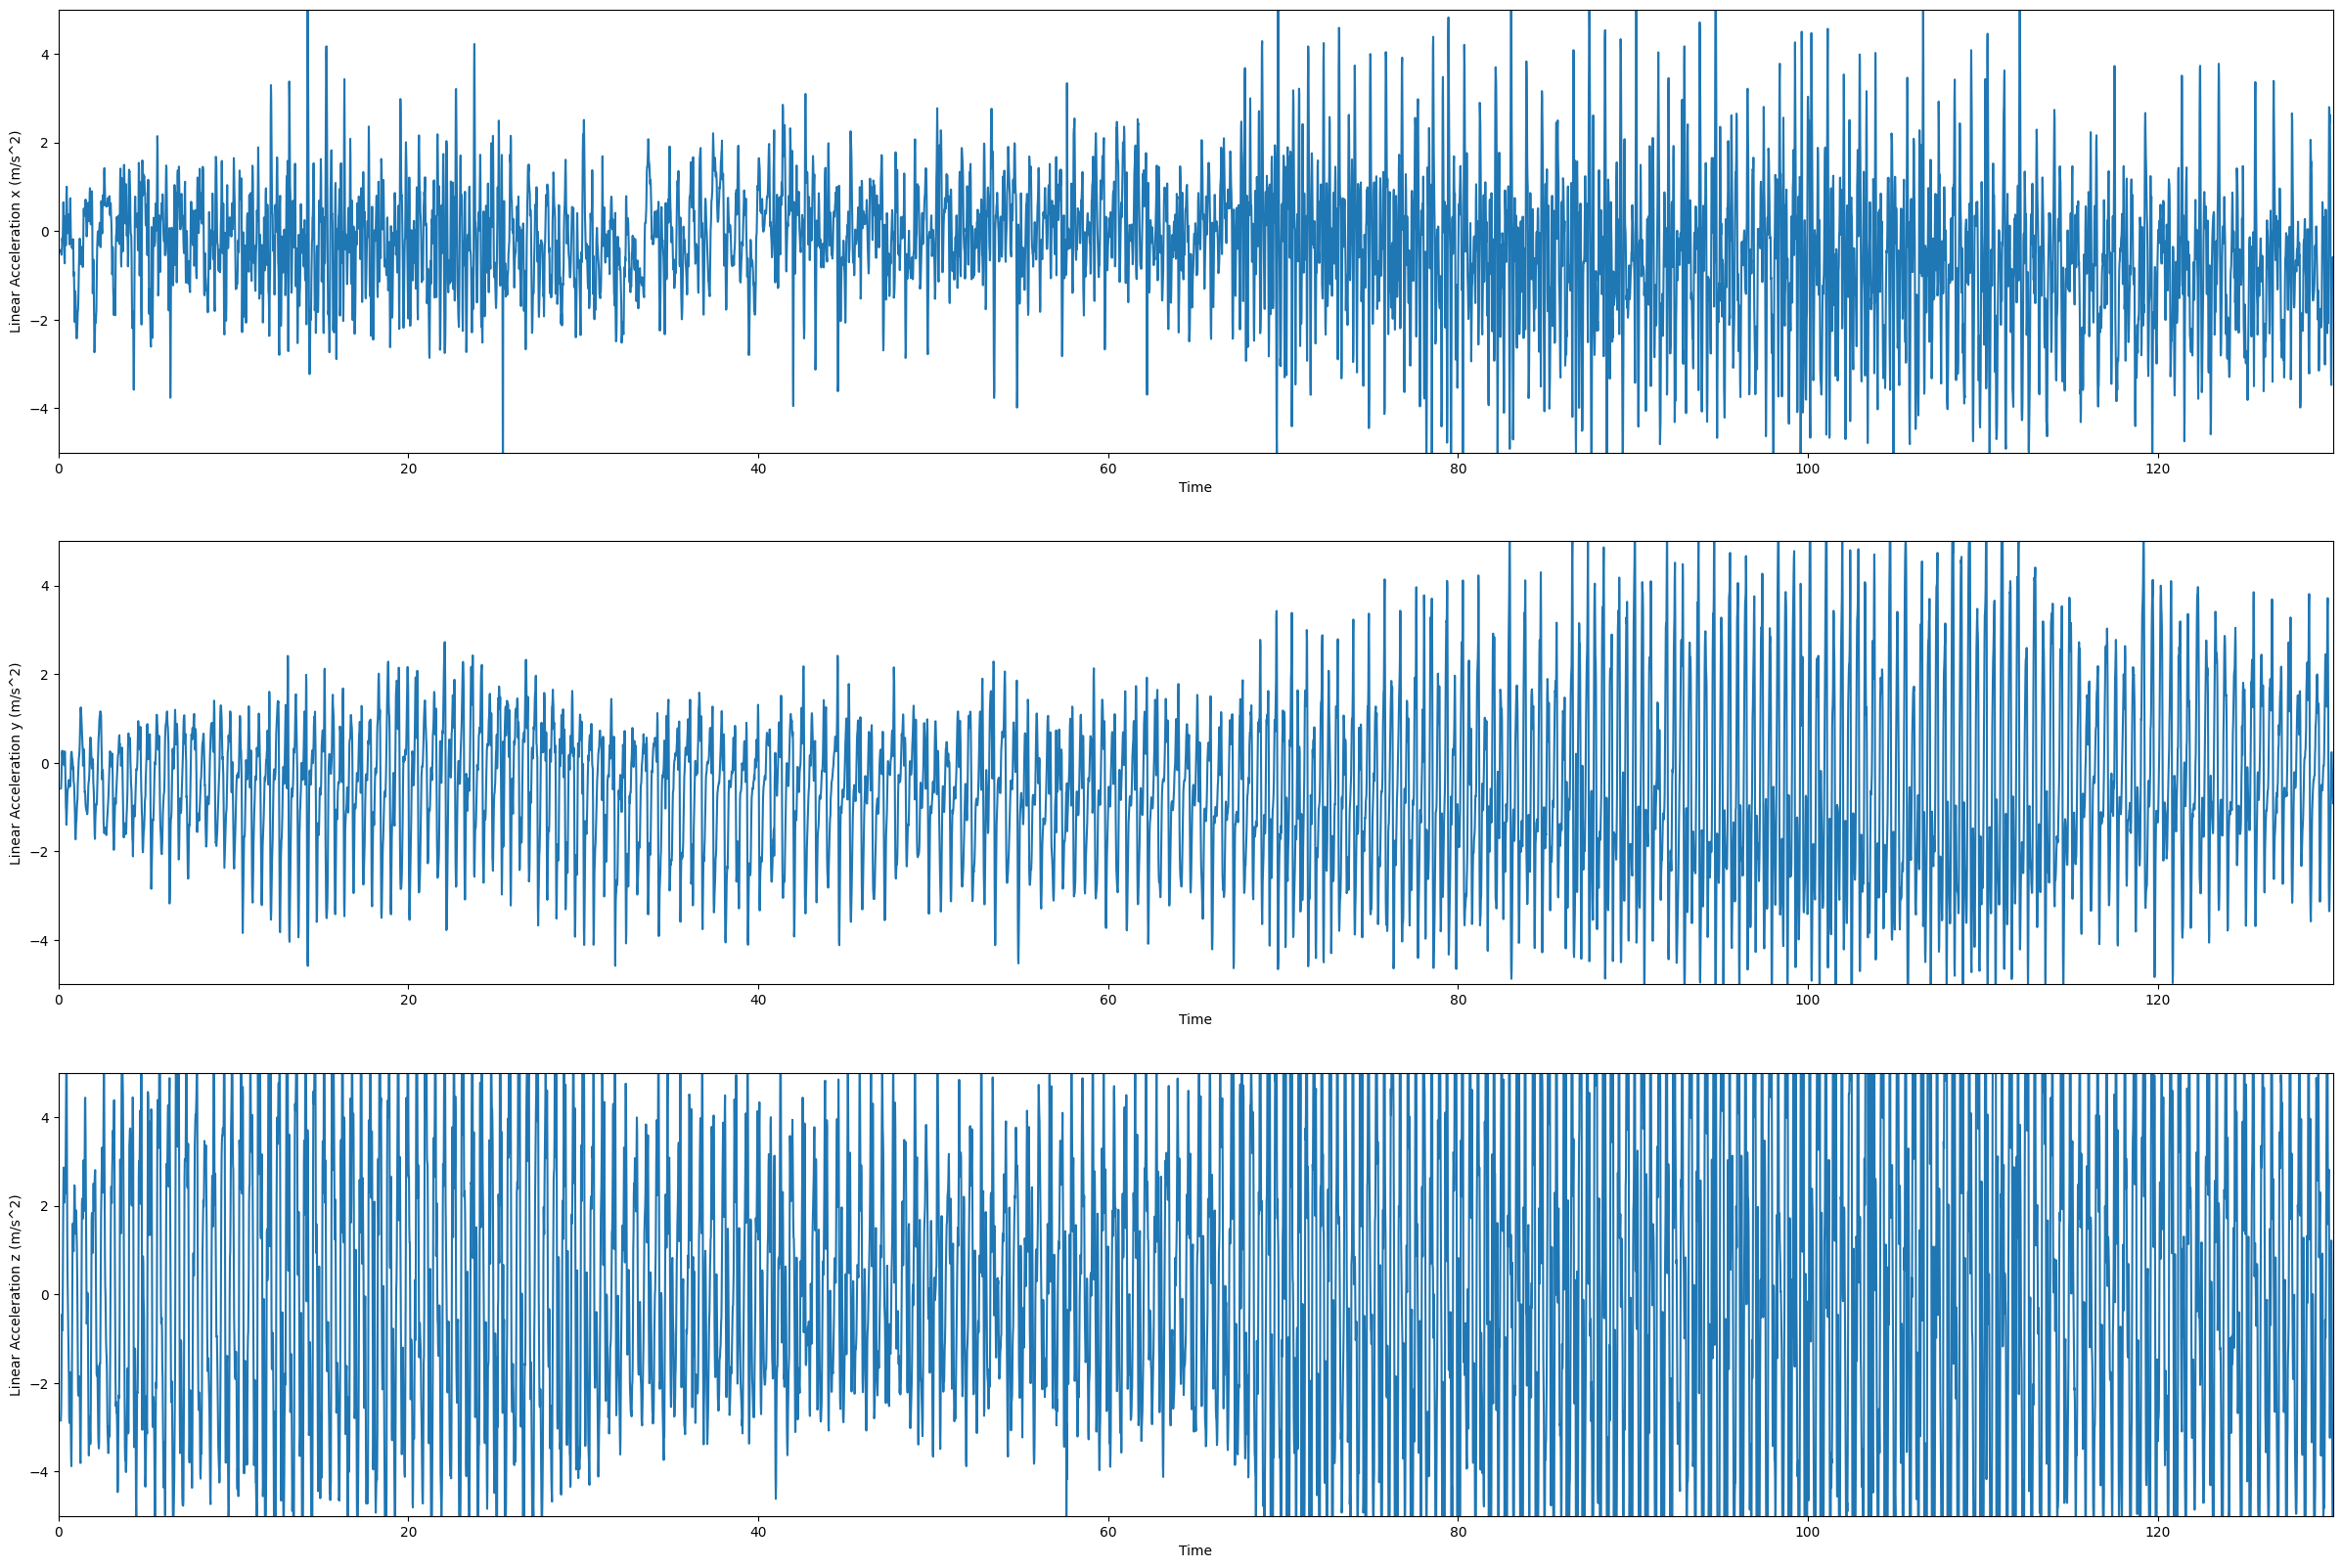

In [39]:
#Kiihtyvyys acceleration datasta
fig = plt.figure(num=None, figsize=(30, 20), dpi=100, facecolor='w', edgecolor='k')

plt.subplot(3,1,1)
plt.plot(df['seconds_elapsed'],df['x'])
plt.grid
plt.xlabel('Time')
plt.ylabel('Linear Acceleration x (m/s^2)')
plt.axis([0,130,-5,5])

plt.subplot(3,1,2)
plt.plot(df['seconds_elapsed'],df['y'])
plt.grid
plt.xlabel('Time')
plt.ylabel('Linear Acceleration y (m/s^2)')
plt.axis([0,130,-5,5])

plt.subplot(3,1,3)
plt.plot(df['seconds_elapsed'],df['z'])
plt.grid
plt.xlabel('Time')
plt.ylabel('Linear Acceleration z (m/s^2)')
plt.axis([0,130,-5,5])

plt.show()

In [80]:
#keskinopeus ja kuljettu matka
def calculate_average_speed_and_distance(data):    
    # Laske etäisyys kahden peräkkäisen pisteen välillä
    data['distance'] = ((data['longitude'].diff() ** 2 + data['latitude'].diff() ** 2) ** 0.5) * 111000   #1 asteen muutos on noin 111km
    
    # Laske aikaero kahden peräkkäisen pisteen välillä
    data['time_diff'] = data['seconds_elapsed'].diff()
    
    # Laske keskinopeus
    data['speed'] = data['distance'] / data['time_diff']  # Nopeus metreinä sekunnissa
    average_speed = data['speed'].mean()

    #kumulatiivinen etäisyys
    data['cumulative_distance'] = data['distance'].cumsum()
    
    return average_speed, data['cumulative_distance'].iloc[-1]

# Laske keskinopeus
avg_speed, total_distance = calculate_average_speed_and_distance(data)
print("Keskinopeus gps datasta:", avg_speed, "metriä sekunnissa")
print("Kuljettu matka gps datasta:", np.round(total_distance), "metriä")

Keskinopeus gps datasta: 2.273839318984554 metriä sekunnissa
Kuljettu matka gps datasta: 295.0 metriä


In [50]:
#askelmäärä suodattamalla kiihtyvyysdatasta
from scipy.signal import butter,filtfilt

def butter_lowpass_filter(data, cutoff, fs, nyq, order):
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def butter_highpass_filter(data, cutoff, fs, nyq, order):
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

Text(0, 0.5, 'Puhdas kiihtyvyys')

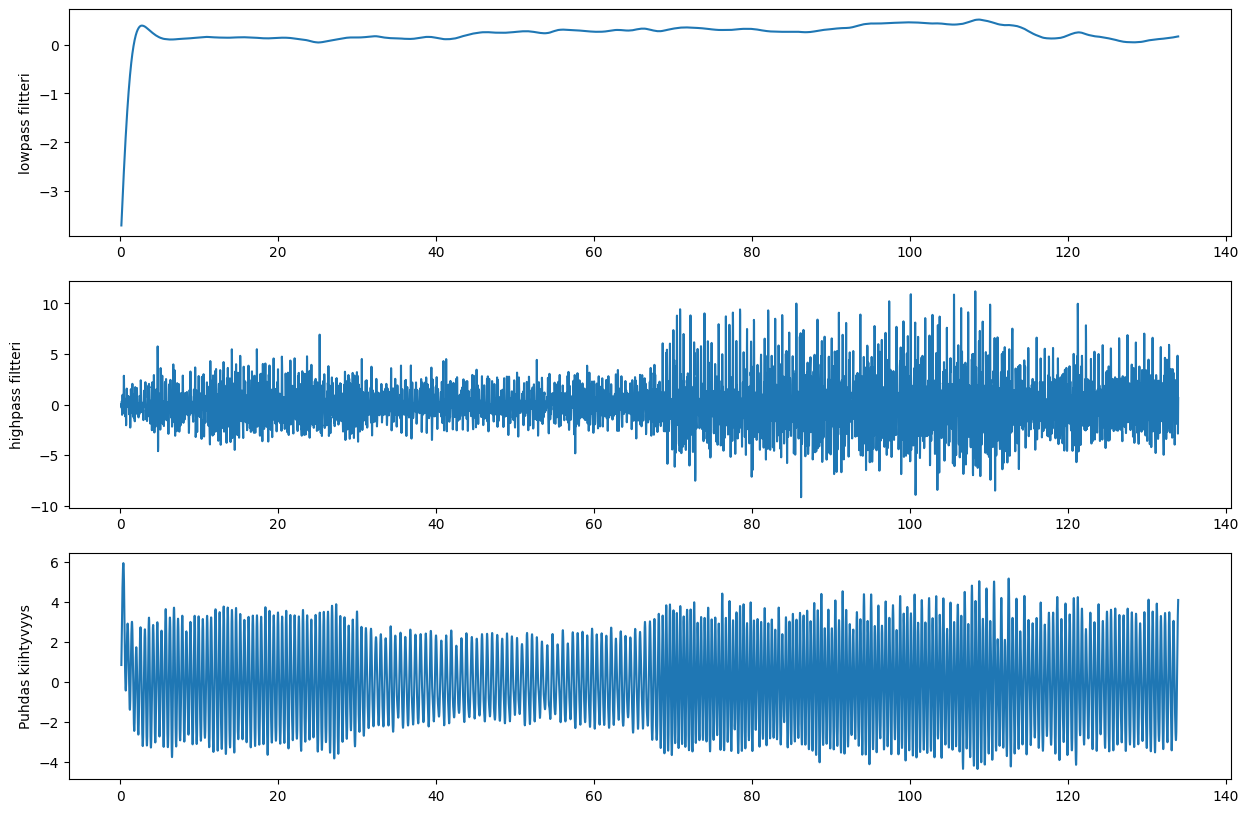

In [79]:
time = df['seconds_elapsed']
noisy_signal = df['z']
cutoff_H = 1/0.4 #Ylipäästösuoditteman cutt-off
cutoff_L = 1/5 #Alipäästösuodattimen cut-off

order = 2
dt = (time[len(time)-1 ] - time[1])/len(time)
fs = 1/dt #Datan sämpälystaajuus
nyq = 0.5 * fs
lowpass_filtered = butter_lowpass_filter(noisy_signal, cutoff_L, fs, nyq, order)
highpass_filtered = butter_highpass_filter(noisy_signal, cutoff_H, fs, nyq, order)
clean_signal = noisy_signal -lowpass_filtered - highpass_filtered

plt.figure(figsize = (15,10))
plt.subplot(3,1,1)
plt.plot(time,lowpass_filtered)
plt.ylabel('lowpass filtteri')
plt.subplot(3,1,2)
plt.plot(time,highpass_filtered)
plt.ylabel('highpass filtteri')
plt.subplot(3,1,3)
plt.plot(time,clean_signal)
plt.ylabel('Puhdas kiihtyvyys')

In [77]:
#askelmäärä laskettuna kiihtyvyyden datasta (1. askelmäärän määritys)
stepdata= clean_signal
steps = 0
for i in range(stepdata.shape[0]-1):
    if stepdata[i]/stepdata[i+1] < 0:
        steps = steps + 0.5
print('Askelmäärä kiihtyvyysdatasta laskettuna on ', steps)

Askelmäärä kiihtyvyysdatasta laskettuna on  256.0


Tehokkain taajuus 1.905 Hz
Tehokkain taajuus vastaa askelaikaa 0.525 s
Askelten määrä on  255.00000000000003


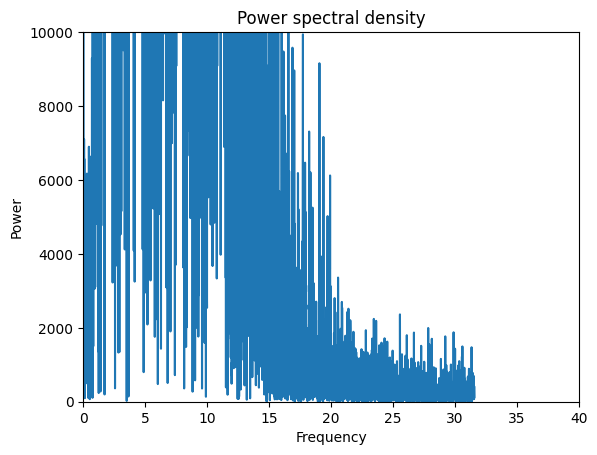

In [76]:
#tehospektri 1
t = df['seconds_elapsed']
f = df['z']

def calculate_power_spectrum(f,t):
    dt = (t[len(t)-1] - t[0])/len(t)
    n = len(f)
    fft = np.fft.fft(f,n)
    PSD = fft*np.conj(fft)
    freq = 1/(dt*n)*np.arange(n)
    L = np.arange(1,np.floor(n/2),dtype = 'int')
    psd = np.array([freq[L],PSD[L].real])
    return psd

psd = calculate_power_spectrum(f,t)
T = t[len(t)-1] - t[0]
plt.plot(psd[0,:],psd[1,:])
plt.title('Power spectral density')
plt.ylabel('Power')
plt.xlabel('Frequency')
plt.axis([0,40,0, 10000])

max_f = psd[0,np.argmax(psd[1,:])]
steps = T*max_f

print('Tehokkain taajuus', np.round(max_f,3), 'Hz')
print('Tehokkain taajuus vastaa askelaikaa', np.round(1/max_f,3), 's')

#Askelmäärä tehospektristä (2. askelmäärän määritys)
steps = T*psd[0,np.argmax(psd[1,:])]
print('Askelten määrä on ',steps)

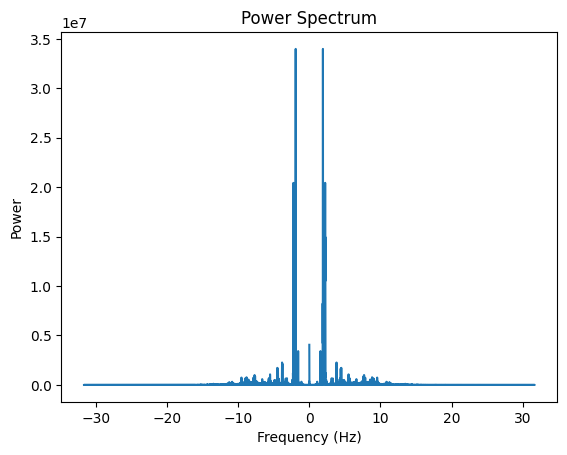

Tehokkain taajuus: 1.9136178593076951 Hz
Tehokkain taajuus vastaa askelaikaa: 0.52257037377451 s
Askelten määrä: 256.0


In [75]:
#Tehospektri 2, askelmäärä tehospektrin avulla 2

signal = df['z']
n = len(signal)
dt = df['seconds_elapsed'].iloc[1] - df['seconds_elapsed'].iloc[0]
fft_result = np.fft.fft(signal)
freq = np.fft.fftfreq(n, d=dt)
power_spectrum = np.abs(fft_result) ** 2

plt.plot(freq, power_spectrum)
plt.title('Power Spectrum')
plt.ylabel('Power')
plt.xlabel('Frequency (Hz)')
plt.show()

max_power_index = np.argmax(power_spectrum)

#Tehokkain taajuus ja askelaika
most_powerful_freq = freq[max_power_index]
step_time = 1 / most_powerful_freq

#Askeleet
total_time = df['seconds_elapsed'].iloc[-1] - df['seconds_elapsed'].iloc[0]
num_steps = total_time / step_time

print('Tehokkain taajuus:', most_powerful_freq, 'Hz')
print('Tehokkain taajuus vastaa askelaikaa:', step_time, 's')
print('Askelten määrä tehospektrillä laskettuna:', np.round(num_steps))

Pohdinta

Vastaako nopeudesta laskettu kiihtyvyys havaittua kiihtyvyyttä? Millaisia eroja havaitset? Mistä ne voivat johtua?
Kuvaajien välillä en huomaa samankaltaisuuksia lainkaan. Ero näkyy kuvaajassa, GPS-datan pohjalta kuvaaja on "selkeä" ja kiihtyvyysdatan puhdas signaali on ns. suttuinen.
GPS-datan avulla lasketun kiihtyvyyden mittaustarkkuus voi olla pienempi, kun taas kiihtyvyyden datasta mittaustarkkuus on suurempi johtuen näytteenotontaajuudesta, antureista. Lisäksi laskumenetelmät ovat erilaiset, mitkä aiheuttaa erilaisia tuloksia.

Arvioitu kuljettu matka on 210-295m välillä. Askelpituus vaihtelee 0,74-0,95m välillä.
Askelmäärä on suurimmillaan 398 askelta, pienimmillään 221 askelta.
Molemmissa testeissä askelmääräksi on saatu 256 askelta. Pidän askelmäärää loogisena, sillä todellisen matkan pituutta ei ole saatu arvioitua puhtaasti eikä ole tietoa mittaajan askelpituudesta. Lisäksi mittaukseen vaikuttaa anturien havaitsemat tärähdykset (kävellessä) sekä ylipäätään askelten havainnointi. Itse testatessa askelmääriä, ongelmana tullut mm. liian pehmeät askeleet mitkä laskevat todellisten askelien tulosta sekä tärähdykset jotka eivät liity askeleeseen, mikä tällöin nostaa todellista arvoa. 